# Target Trial Emulation in Python

This notebook outlines the steps for implementing a Target Trial Emulation in Python by converting an R tutorial into Python code. We use **pandas** for data handling and **statsmodels** for model fitting. The workflow includes:

1. **Setup and Data Preparation:**  
   - Load and preview the data from `data_censored.csv`.

2. **Weight Models for Treatment Switching and Censoring:**  
   - Fit logistic regression models to compute inverse probability weights.

3. **Outcome Model:**  
   - Fit a marginal structural model (MSM) using the estimated weights.

4. **Data Expansion and Inference:**  
   - Simulate the expansion of the dataset into multiple trial periods.  
   - Estimate survival probabilities and cumulative incidences for different treatment scenarios.

**Note:** The original R code uses the `TrialEmulation` package. Here, we replicate key steps using Python libraries.


## 1. Setup and Data Preparation

We load the observational data from `data_censored.csv` and display the first few rows. This dataset contains columns like `id`, `period`, `treatment`, `outcome`, and others.


In [46]:
# Load the data
data = pd.read_csv("data_censored.csv")
# Display first few rows
data.head()


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


## 2. Fitting Weight Models for Treatment Switching and Censoring

In the target trial emulation, we must account for censoring and treatment switching. We estimate inverse probability weights using logistic regression models.

### Treatment Switching Weights Analysis

In the target trial emulation framework, treatment switching weights are used to adjust for potential bias arising from patients deviating from their assigned treatment. We calculate these weights by fitting two logistic regression models:

- **Numerator Model:** Estimates the probability of receiving treatment based solely on a key variable (here, `age`).
- **Denominator Model:** Estimates the probability using additional covariates (here, `age`, `x1`, and `x3`).

The stabilized weight is then computed as the ratio of these predicted probabilities (numerator/denominator). 

#### What to Look For:
- **Good Calibration:**  
  A distribution centered around 1 indicates that the numerator and denominator models yield similar probabilities. This suggests that the weight model is well-calibrated and is not overly inflating or deflating the weights.
- **Potential Issues:**  
  A wide spread or many extreme values (very high or low weights) may signal model misspecification or poor overlap between treatment groups. Extreme weights can lead to unstable estimates in the outcome model.

Below, the histogram of treatment switching weights is plotted along with summary statistics (median, mean, and standard deviation) to help assess the distribution. Generally, weights that are centered around 1 with a moderate spread are desirable.



In [47]:
# Numerator model for treatment switching
formula_num = "treatment ~ age"
model_num = smf.logit(formula=formula_num, data=data).fit(disp=False)
data['p_num'] = model_num.predict(data)

# Denominator model for treatment switching
formula_den = "treatment ~ age + x1 + x3"
model_den = smf.logit(formula=formula_den, data=data).fit(disp=False)
data['p_den'] = model_den.predict(data)

# Stabilized weight for treatment switching (avoid division by zero)
data['switch_weight'] = np.where(data['p_den'] > 0, data['p_num'] / data['p_den'], 1)

print("Treatment Switching Weight Models:")
print(model_num.summary())
print(model_den.summary())


Treatment Switching Weight Models:
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04144
Time:                        16:55:01   Log-Likelihood:                -480.24
converged:                       True   LL-Null:                       -501.01
Covariance Type:            nonrobust   LLR p-value:                 1.163e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8867      0.333      5.671      0.000       1.235       2.539
age           -0.0421      0.007     -6.213      0.000      -0.055      -0.029
                 

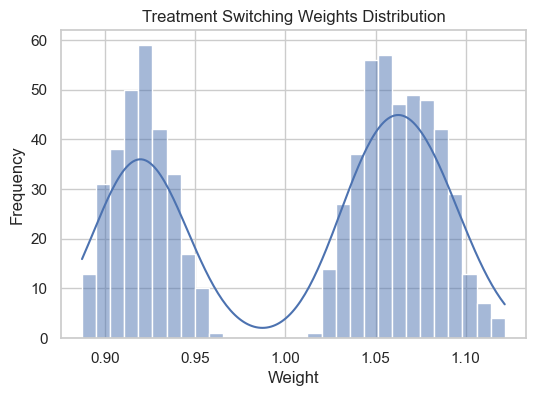

Median Weight: 1.041873022422794
Mean Weight: 1.00567867467341
Standard Deviation: 0.07332259265524313


In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the distribution of treatment switching weights
plt.figure(figsize=(6,4))
sns.histplot(data['switch_weight'], bins=30, kde=True)
plt.title('Treatment Switching Weights Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

# Brief Analysis
median_weight = data['switch_weight'].median()
mean_weight = data['switch_weight'].mean()
std_weight = data['switch_weight'].std()

print("Median Weight:", median_weight)
print("Mean Weight:", mean_weight)
print("Standard Deviation:", std_weight)

# A well-calibrated model would typically have weights centered around 1 with a moderate spread.


### 2. Censoring Weights Analysis

In target trial emulation, censoring weights adjust for bias due to informative censoring—when the probability of a subject dropping out or being censored is related to their covariates or outcome. We estimate these weights using two logistic regression models:

- **Numerator Model:**  
  This model estimates the probability of *not being censored* (i.e., `1 - censored`) based solely on a key variable (`x2` in our case).
  
- **Denominator Model:**  
  This model uses additional covariates (`x2` and `x1`) to estimate the same probability.

The stabilized censoring weight is computed as the ratio of the predicted probabilities from the numerator model to that of the denominator model.

#### What to Look For:
- **Good Calibration:**  
  The weights should be centered around 1. This indicates that the simpler model (numerator) and the more complex model (denominator) yield similar estimates, suggesting that censoring is not strongly confounded by the extra variables.
  
- **Potential Issues:**  
  A large spread or many extreme weights (values significantly higher or lower than 1) might indicate model misspecification or strong confounding. Extreme censoring weights can result in unstable estimates in subsequent analyses.

The following visualization displays the histogram of censoring weights along with summary statistics (median, mean, and standard deviation) to help evaluate their distribution. Ideally, the weights should exhibit a moderate spread with most values clustering around 1.


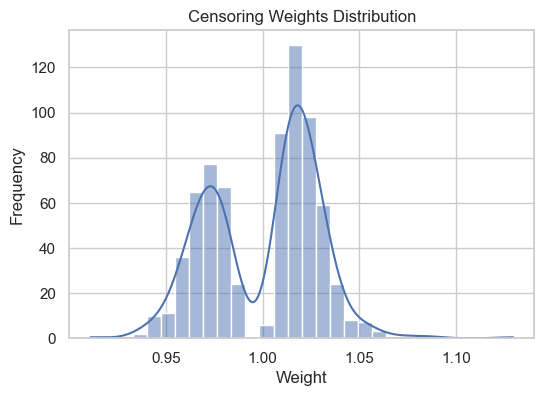

Censoring Weights Summary:
Median: 1.011273877253797
Mean: 1.0008250880585206
Standard Deviation: 0.028268799992005784


In [66]:
# Visualizing the distribution of censoring weights
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.histplot(data['censor_weight'], bins=30, kde=True)
plt.title('Censoring Weights Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

# Calculate summary statistics for censoring weights
median_cens = data['censor_weight'].median()
mean_cens = data['censor_weight'].mean()
std_cens = data['censor_weight'].std()

print("Censoring Weights Summary:")
print("Median:", median_cens)
print("Mean:", mean_cens)
print("Standard Deviation:", std_cens)


In [48]:
# Create a new variable: probability of NOT being censored
data['not_censored'] = 1 - data['censored']

# Numerator model for censoring
formula_cens_num = "not_censored ~ x2"
model_cens_num = smf.logit(formula=formula_cens_num, data=data).fit(disp=False)
data['p_cens_num'] = model_cens_num.predict(data)

# Denominator model for censoring
formula_cens_den = "not_censored ~ x2 + x1"
model_cens_den = smf.logit(formula=formula_cens_den, data=data).fit(disp=False)
data['p_cens_den'] = model_cens_den.predict(data)

# Calculate the censoring weights
data['censor_weight'] = np.where(data['p_cens_den'] > 0, data['p_cens_num'] / data['p_cens_den'], 1)

print("Censoring Weight Models:")
print(model_cens_num.summary())
print(model_cens_den.summary())


Censoring Weight Models:
                           Logit Regression Results                           
Dep. Variable:           not_censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        16:55:21   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4481      0.141     17.415      0.000       2.173       2.724
x2            -0.4486      0.137     -3.278      0.001      -0.717      -0.180
                           

## 3. Outcome Model

We now build an outcome model using a logistic regression approach. The outcome is regressed on:
- **Treatment (assigned_treatment)**
- **x2**
- **Followup time and its square**
- **Trial period and its square**

For demonstration purposes, we create new columns for `followup_time` and `trial_period` based on the `period` column.

Weights for the outcome model are derived from the product of the treatment switching and censoring weights.


In [ ]:
plt.subplot(1,3,3)
sns.histplot(data['final_weight'], bins=30, kde=True)
plt.title('Final Combined Weights')

In [50]:
# For demonstration, let followup_time = period and trial_period = period
data['followup_time'] = data['period']
data['trial_period'] = data['period']

# Create the square terms
data['followup_time_sq'] = data['followup_time'] ** 2
data['trial_period_sq'] = data['trial_period'] ** 2

# Define the treatment assignment (for illustration, we assume it is the same as 'treatment')
data['assigned_treatment'] = data['treatment']

# Compute final weight as the product of switch and censoring weights
data['final_weight'] = data['switch_weight'] * data['censor_weight']

# Fit the outcome model using weighted logistic regression
formula_outcome = ("outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq + "
                   "trial_period + trial_period_sq")
outcome_model = smf.glm(formula=formula_outcome, data=data, 
                        family=sm.families.Binomial(), weights=data['final_weight']).fit()
print("Outcome Model Summary:")
print(outcome_model.summary())


Outcome Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                      720
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54.806
Date:                Sun, 09 Mar 2025   Deviance:                       109.61
Time:                        16:56:19   Pearson chi2:                     726.
No. Iterations:                    51   Pseudo R-squ. (CS):           0.005999
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

C:\Users\justi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


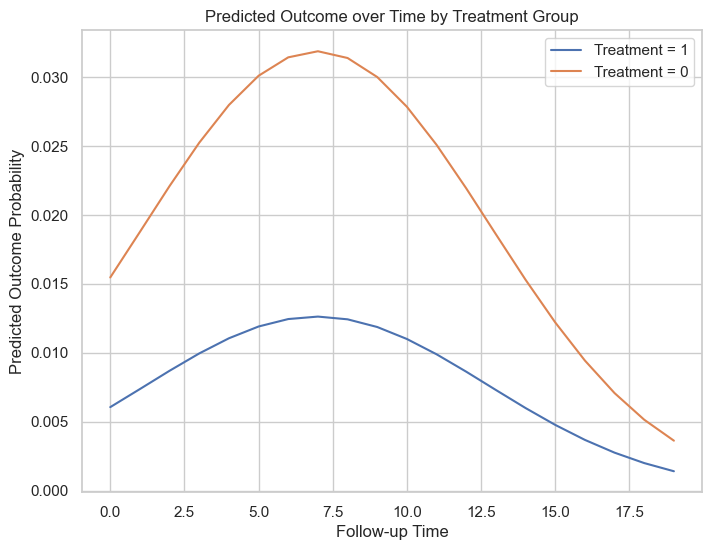

In [64]:
# Simulate predictions for a range of followup times
followup_times = np.arange(0, data['followup_time'].max()+1)
predictions = {}

for treatment in [0, 1]:
    temp_data = data.copy()
    temp_data['assigned_treatment'] = treatment
    pred_probs = []
    for t in followup_times:
        temp_data['followup_time'] = t
        temp_data['followup_time_sq'] = t**2
        # For simplicity, assume trial_period equals followup_time
        temp_data['trial_period'] = t
        temp_data['trial_period_sq'] = t**2
        pred = outcome_model.predict(temp_data)
        pred_probs.append(np.mean(pred))
    predictions[treatment] = pred_probs

plt.figure(figsize=(8,6))
plt.plot(followup_times, predictions[1], label='Treatment = 1')
plt.plot(followup_times, predictions[0], label='Treatment = 0')
plt.xlabel("Follow-up Time")
plt.ylabel("Predicted Outcome Probability")
plt.title("Predicted Outcome over Time by Treatment Group")
plt.legend()
plt.show()


## 4. Expanding Trials and Inference

In the original R workflow the dataset is expanded to form a sequence of target trials. Here, we simulate a simple expansion by grouping the data into chunks by patient ID (or by period).

For inference, we predict survival probabilities or cumulative incidences over followup times. In this example, we simulate predictions by using the fitted outcome model to calculate the probability of the outcome for a range of followup times.


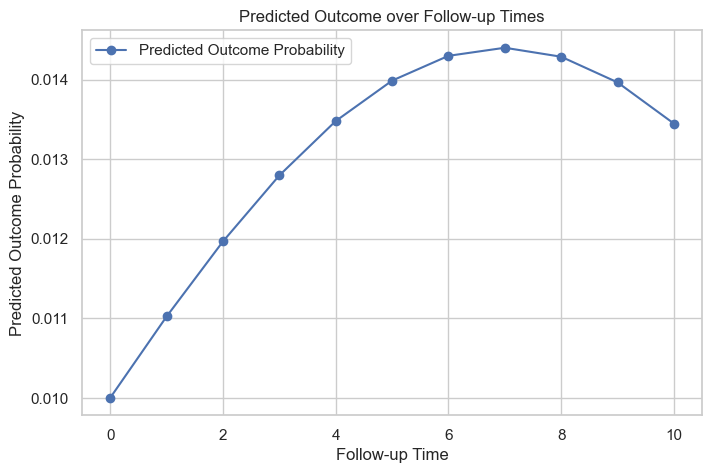

In [51]:
# For simplicity, we simulate "expanded" trial data by taking a subset (or by copying rows with additional followup times)
# Here, we assume each patient has multiple followup times and we use the existing 'period' as followup time.

# Suppose we want to predict outcomes for followup times 0 to 10 for trial_period == 1.
unique_trial_period = 1
predict_times = np.arange(0, 11)

# Filter data for trial_period == 1 (if available)
trial_data = data[data['trial_period'] == unique_trial_period].copy()

# For demonstration, we will compute predicted outcome probabilities for each followup time for each observation
predictions = []
for t in predict_times:
    trial_data['followup_time'] = t
    trial_data['followup_time_sq'] = t**2
    # Predict probability using the outcome model
    pred = outcome_model.predict(trial_data)
    predictions.append(pred.mean())  # average prediction for demonstration

# Plot the predicted probabilities over followup times
plt.figure(figsize=(8, 5))
plt.plot(predict_times, predictions, marker='o', label='Predicted Outcome Probability')
plt.xlabel("Follow-up Time")
plt.ylabel("Predicted Outcome Probability")
plt.title("Predicted Outcome over Follow-up Times")
plt.legend()
plt.grid(True)
plt.show()


## Summary

In this notebook we converted an R-based target trial emulation workflow into Python code. We:

- Loaded and explored the observational data.
- Estimated treatment switching and censoring weights using logistic regression.
- Built an outcome model with inverse probability weighting.
- Simulated trial expansion and inferred predicted outcome probabilities over time.

This workflow illustrates how causal inference techniques like marginal structural models can be implemented in Python using standard data science libraries.
